# Задача 5 (бонусная): экспериментальное исследование алгоритмов для регулярных запросов #

## Подготовка окружения ##

Для исполнения кода необходима система с ядром Linux.

Установка необходимых зависимостей:

In [ ]:
!pip install -r requirements.txt && pip install pycubool matplotlib

## Введение ##
В данной работе рассматривается задача достижимости в графе с регулярными ограничениями. Исследуется производительность её решений с использованием библиотек для работы с разреженными матрицами [scipy.sparse](https://github.com/scipy/scipy) и [pycubool](https://github.com/JetBrains-Research/cuBool).

### О задаче достижимости ###
Пусть дан конечный ориентированный помеченный граф $G = (V, E, L)$, в котором каждому пути $\pi \in E^*$, состоящему из рёбер с метками $l_1, ..., l_n \in L$, сопоставляется слово по правилу $\omega(\pi) = l_1 * ... * l_n$, где $*$ --- конкатенация.

Пусть также дано регулярное выражение $R$.

Рассмотрим три варианта постановки задачи о достижимости в графе $G$ с регулярными ограничениями, заданными $R$.

#### 1. Достижимость между всеми парами вершин####
Требуется найти пары вершин $G$, что между ними существует путь, которому сопоставляется слово из языка, задаваемого $R$. Формально говоря, требуется найти множество $\{(v_i, v_j) \in V^2: \exists \pi \in E^*: start(\pi) = v_i, final(\pi) = v_j, \omega(\pi) \in language(R)\}$.

Далее обозначим $V_S$ множество стартовых вершин, $V_F$ множество финальных вершин. 

#### 2. Достижимость для всего множества заданных вершин####

Требуется найти все финальные вершины, что до них существуют пути из стартовых, которым сопоставляются слова из языка, задаваемого $R$. Формально говоря, требуется найти множество $\{v_i \in V_F: \exists \pi \in E^*: start(\pi) \in V_S, final(\pi) = v_j, \omega(\pi) \in language(R)\}$.

#### 3. Достижимость для каждой вершины из заданного множества стартовых вершин####

Требуется найти множество пар вершин-начал и вершин-концов путей, которым сопоставляются слова из языка, задаваемого $R$ Формально говоря, требуется найти множество $\{(v_i, v_j) \in V_S \times V_F: \exists \pi \in E^*: start(\pi) = v_i, final(\pi) = v_j, \omega(\pi) \in language(R)\}$





## Исследуемые решения ##

Рассмотрим краткие идеи решения каждой задачи:

#### 1. Достижимость между всеми парами вершин####
По графу и регулярному выражению строятся конечные автоматы, представленные в виде разреженных булевых матриц, а затем ищется их пересечение с помощью тензорного произведения. Финальном шагом является подсчет транзитивного замыкания пересечения автоматов.

#### 2. Достижимость для всего множества заданных вершин ####
Аналогично по графу и регулярному выражению строятся конечные автоматы, а затем производится синхронный поиск в ширину с помощью матричного произведения.

#### 3. Достижимость для каждой вершины из заданного множества стартовых вершин ####
Аналогично задаче 2, однако фронт (матрица, отражающая в каких состояниях мы находимся на текущей итерации поиска в ширину) имеет расширенный вид, поскольку требуется поддерживать информацию для каждой стартовой вершины графа отдельно.




## Реализация

Представленные реализации алгоритмов с помощью библиотек **scipy.sparse** и **pycubool** идентичны. 

На основе **scipy.sparse** представлена в модуле `project.rpq`

In [ ]:
from project.rpq import *

На основе **pycubool**:

In [ ]:
from typing import Dict, Set, Any, List

from pyformlang.finite_automaton import State, EpsilonNFA

from pycubool import Matrix


class BoolMatrixAutomatonPyCuBool:
    # Only for internal use
    def __init__(
        self,
        state_to_idx: Dict[State, int],
        start_states: Set[State],
        final_states: Set[State],
        b_mtx: Dict[Any, Matrix],
    ):
        """Class represents bool matrix representation of automaton

        Attributes
        ----------

        state_to_idx : Dict[State, int]
            Mapping from states to indices in boolean matrix
        start_states : Set[State]
            Set of start states
        final_states : Set[State]
            Set of final states
        b_mtx: Dict[Any, dok_matrix]
            Mapping from edge label to boolean adjacency matrix
        """
        self.state_to_idx = state_to_idx
        self.start_states = start_states
        self.final_states = final_states
        self.b_mtx = b_mtx

    def __and__(
        self, other: "BoolMatrixAutomatonPyCuBool"
    ) -> "BoolMatrixAutomatonPyCuBool":
        """Calculates intersection of two automatons represented by bool matrices

        Parameters
        ----------
        other : BoolMatrixAutomatonPyCuBool
            The automaton with which intersection will be calculated

        Returns
        -------
        intersection : BoolMatrixAutomatonPyCuBool
            Intersection of two automatons represented by bool matrix
        """
        inter_labels = self.b_mtx.keys() & other.b_mtx.keys()
        inter_b_mtx = {
            label: self.b_mtx[label].kronecker(other.b_mtx[label])
            for label in inter_labels
        }
        inter_state_to_idx = dict()
        inter_start_states = set()
        inter_final_states = set()
        for self_state, self_idx in self.state_to_idx.items():
            for other_state, other_idx in other.state_to_idx.items():
                state = State((self_state.value, other_state.value))
                idx = self_idx * len(other.state_to_idx) + other_idx
                inter_state_to_idx[state] = idx
                if (
                    self_state in self.start_states
                    and other_state in other.start_states
                ):
                    inter_start_states.add(state)
                if (
                    self_state in self.final_states
                    and other_state in other.final_states
                ):
                    inter_final_states.add(state)
        return BoolMatrixAutomatonPyCuBool(
            state_to_idx=inter_state_to_idx,
            start_states=inter_start_states,
            final_states=inter_final_states,
            b_mtx=inter_b_mtx,
        )

    def transitive_closure(self) -> Matrix:
        """Calculates transitive closure

        Returns
        -------
        transitive_closure : Matrix
            Transitive closure represented by sparse matrix
        """
        state_count = max(len(self.state_to_idx), 1)
        transitive_closure = Matrix.empty((state_count, state_count))
        for b_mtx in self.b_mtx.values():
            transitive_closure = transitive_closure.ewiseadd(b_mtx)

        prev_nnz, cur_nnz = None, transitive_closure.nvals
        if not cur_nnz:
            return transitive_closure

        while prev_nnz != cur_nnz:
            transitive_closure.mxm(
                transitive_closure, out=transitive_closure, accumulate=True
            )
            prev_nnz, cur_nnz = cur_nnz, transitive_closure.nvals
        return transitive_closure

    @classmethod
    def from_nfa(cls, nfa: EpsilonNFA) -> "BoolMatrixAutomatonPyCuBool":
        """Builds bool matrix from nfa

        Parameters
        ----------
        nfa : EpsilonNFA
            NFA to be converted to bool matrix

        Returns
        -------
        bool_matrix : BoolMatrixAutomatonPyCuBool
            Bool matrix representation of automaton
        """
        state_to_idx = {state: idx for idx, state in enumerate(nfa.states)}
        return cls(
            state_to_idx=state_to_idx,
            start_states=nfa.start_states.copy(),
            final_states=nfa.final_states.copy(),
            b_mtx=cls._b_mtx_from_nfa(
                nfa=nfa,
                state_to_idx=state_to_idx,
            ),
        )

    @staticmethod
    def _b_mtx_from_nfa(
        nfa: EpsilonNFA, state_to_idx: Dict[State, int]
    ) -> Dict[Any, Matrix]:
        """Utility method for creating mapping from labels to adj bool matrix

        Parameters
        ----------
        nfa : EpsilonNFA
            Epsilon NFA from which mapping will be created
        state_to_idx: Dict[State, int]
            Mapping from states to indices in boolean matrix

        Returns
        -------
        b_mtx : Dict[State, int]
            Mapping from labels to adj bool matrix
        """
        b_mtx = dict()
        state_from_to_transitions = nfa.to_dict()
        for label in nfa.symbols:
            mtx = Matrix.empty((len(nfa.states), len(nfa.states)))
            for state_from, transitions in state_from_to_transitions.items():
                states_to = transitions.get(label, set())
                if not isinstance(states_to, set):
                    states_to = {states_to}
                for state_to in states_to:
                    mtx[state_to_idx[state_from], state_to_idx[state_to]] = True
            b_mtx[label] = mtx
        return b_mtx

    def _direct_sum(
        self, other: "BoolMatrixAutomatonPyCuBool"
    ) -> "BoolMatrixAutomatonPyCuBool":
        """Calculates direct sum of automatons represented by bool matrix

        Parameters
        ----------
        other : BoolMatrixAutomatonPyCuBool
            The matrix with which sum will be calculated

        Returns
        -------
        direct_sum : BoolMatrixAutomatonPyCuBool
            Direct sum
        """
        shifted_state_to_idx = {
            state: len(self.state_to_idx) + idx
            for state, idx in other.state_to_idx.items()
        }
        state_to_idx = {**self.state_to_idx, **shifted_state_to_idx}
        start_states = self.start_states | other.start_states
        final_states = self.final_states | other.final_states
        b_mtx = dict()
        for label in self.b_mtx.keys() & other.b_mtx.keys():
            mtx = Matrix.empty((len(state_to_idx), len(state_to_idx)))
            for i, j in self.b_mtx[label]:
                mtx[i, j] = True
            for i, j in other.b_mtx[label]:
                mtx[len(self.state_to_idx) + i, len(self.state_to_idx) + j] = True
            b_mtx[label] = mtx
        return BoolMatrixAutomatonPyCuBool(
            state_to_idx=state_to_idx,
            start_states=start_states,
            final_states=final_states,
            b_mtx=b_mtx,
        )

    def sync_bfs(
        self,
        other: "BoolMatrixAutomatonPyCuBool",
        reachable_per_node: bool,
    ) -> Set[Any]:
        """Executes sync bfs on two automatons represented by bool matrices

        Parameters
        ----------
        other : BoolMatrixAutomatonPyCuBool
            The matrix with which bfs will be executed
        reachable_per_node: bool
            Means calculates reachability for each node separately or not

        Returns
        -------
        result : Set[Any]
            Result depends on reachable_per_node
        if reachable_per_node is false -- set of reachable nodes
        if reachable_per_node is true -- set of tuples (U, V)
        where U is start node and V is final node reachable from U
        """

        if not self.state_to_idx or not other.state_to_idx:
            return set()

        ordered_start_states = list(self.start_states)

        direct_sum = other._direct_sum(self)
        initial_front = self._init_sync_bfs_front(
            other=other,
            reachable_per_node=reachable_per_node,
            ordered_start_states=ordered_start_states,
        )

        front = self._copy_mtx(initial_front)
        visited = self._copy_mtx(front)

        other_states_num = len(other.state_to_idx)

        while True:
            visited_nnz = visited.nvals
            new_front = self._copy_mtx(front)

            for _, mtx in direct_sum.b_mtx.items():
                product: Matrix = front.mxm(mtx)
                new_front_step = Matrix.empty(product.shape)
                for i, j in product:
                    if j >= other_states_num:
                        continue
                    row = product[i : i + 1, other_states_num:]
                    if not row.nvals:
                        continue
                    row_shift = i // other_states_num * other_states_num
                    new_front_step[row_shift + j, j] = True
                    for _, rj in row:
                        new_front_step[row_shift + j, other_states_num + rj] = True
                new_front = new_front.ewiseadd(new_front_step)

            new_front_without_visited = Matrix.empty(new_front.shape)
            for i, j in set(new_front.to_list()).difference(set(visited.to_list())):
              new_front_without_visited[i, j] = True

            visited = visited.ewiseadd(new_front_without_visited)
            front = new_front_without_visited

            if visited_nnz == visited.nvals:
                break

        self_idx_to_state = {idx: state for state, idx in self.state_to_idx.items()}
        other_idx_to_state = {idx: state for state, idx in other.state_to_idx.items()}

        result = set()
        nonzero = set(visited.to_list()).difference(set(initial_front.to_list()))
        for i, j in nonzero:
            if (
                other_idx_to_state[i % other_states_num] not in other.final_states
                or j < other_states_num
            ):
                continue
            self_state = self_idx_to_state[j - other_states_num]
            if self_state not in self.final_states:
                continue
            result.add(
                self_state.value
                if not reachable_per_node
                else (
                    ordered_start_states[i // other_states_num].value,
                    self_state.value,
                )
            )
        return result

    @staticmethod
    def _copy_mtx(matrix: Matrix) -> Matrix:
        """Makes copy of given matrix

        Parameters
        ----------
        matrix : Matrix
            Matrix to be copied

        Returns
        -------
        copy : Matrix
            Copy of matrix
        """
        copy = Matrix.empty(matrix.shape)
        for i, j in matrix:
            copy[i, j] = True
        return copy

    def _init_sync_bfs_front(
        self,
        other: "BoolMatrixAutomatonPyCuBool",
        reachable_per_node: bool,
        ordered_start_states: List[State],
    ) -> Matrix:
        """Initializes front for sync bfs

        Parameters
        ----------
        other : BoolMatrixAutomatonPyCuBool
            The matrix with which bfs will be executed
        reachable_per_node: bool
            Means calculates reachability for each node separately or not
            ordered_start_states: List[State]
            List of start states

        Returns
        -------
        result : csr_matrix
            Initial front for sync bfs
        """

        def front_with_self_start_row(self_start_row: List):
            front = Matrix.empty(
                (
                    len(other.state_to_idx),
                    len(self.state_to_idx) + len(other.state_to_idx),
                )
            )
            for state in other.start_states:
                idx = other.state_to_idx[state]
                front[idx, idx] = True
                for i, item in enumerate(self_start_row):
                    if item:
                        front[idx, len(other.state_to_idx) + i] = item
            return front

        if not reachable_per_node:
            start_indices = set(
                self.state_to_idx[state] for state in ordered_start_states
            )
            return front_with_self_start_row(
                [idx in start_indices for idx in range(len(self.state_to_idx))]
            )

        fronts = [
            front_with_self_start_row(
                [
                    idx == self.state_to_idx[start]
                    for idx in range(len(self.state_to_idx))
                ]
            )
            for start in ordered_start_states
        ]

        mtx = Matrix.empty(
            (
                len(fronts) * len(other.state_to_idx),
                len(other.state_to_idx) + len(self.state_to_idx),
            )
        )
        for front_number, front in enumerate(fronts):
            for i, j in front:
                mtx[len(other.state_to_idx) * front_number + i, j] = True
        return mtx


In [ ]:
from typing import Set, Optional, Tuple, Any, Callable

from networkx import MultiDiGraph
from pyformlang.regular_expression import Regex

from project import (
    graph_to_epsilon_nfa,
    regex_to_min_dfa,
)

def rpq_tensor_pycubool(
    graph: MultiDiGraph,
    query: Regex,
    start_states: Optional[Set],
    final_states: Optional[Set],
) -> Set[Tuple[Any, Any]]:
    """Executes regular query on graph using tensor multiplication

    Parameters
    ----------
    graph : MultiDiGraph
        The graph on which query will be executed
    query: Regex
        Query represented by regular expression
    start_states: Optional[Set]
        Set of nodes of the graph that will be treated as start states in NFA
        If parameter is None then each graph node is considered the start state
    final_states: Optional[Set]
        Set of nodes of the graph that will be treated as final states in NFA
        If parameter is None then each graph node is considered the final state

    Returns
    -------
    result : Set[Tuple[Any, Any]]
        The set of pairs where the node in second place is reachable
         from the node in first place with a constraint on a given query
    """
    nfa_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        graph_to_epsilon_nfa(
            graph=graph,
            start_states=start_states,
            final_states=final_states,
        )
    )
    query_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        regex_to_min_dfa(regex=query),
    )
    intersection_bool_mtx = nfa_bool_mtx & query_bool_mtx
    idx_to_state = {
        idx: state for state, idx in intersection_bool_mtx.state_to_idx.items()
    }
    transitive_closure = intersection_bool_mtx.transitive_closure()
    result = set()
    for state_from_idx, state_to_idx in transitive_closure:
        state_from, state_to = idx_to_state[state_from_idx], idx_to_state[state_to_idx]
        if (
            state_from in intersection_bool_mtx.start_states
            and state_to in intersection_bool_mtx.final_states
        ):
            state_from_graph_value, _ = state_from.value
            state_to_graph_value, _ = state_to.value
            result.add(
                (state_from_graph_value, state_to_graph_value),
            )
    return result


def rpq_bfs_pycubool(
    graph: MultiDiGraph,
    query: Regex,
    start_states: Optional[Set],
    final_states: Optional[Set],
    mode: MultipleSourceRpqMode,
) -> Set[Any]:
    """Executes regular query on graph using multiple source bfs

    Parameters
    ----------
    graph : MultiDiGraph
        The graph on which query will be executed
    query: Regex
        Query represented by regular expression
    start_states: Optional[Set]
        Set of nodes of the graph that will be treated as start states in NFA
        If parameter is None then each graph node is considered the start state
    final_states: Optional[Set]
        Set of nodes of the graph that will be treated as final states in NFA
        If parameter is None then each graph node is considered the final state
    mode: MultipleSourceRpqMode
        The mode that determines which vertices should be found

    Returns
    -------
    result : Set[Any]
        Result depends on chosen mode
        if mode is FIND_ALL_REACHABLE -- set of reachable nodes
        if mode is FIND_REACHABLE_FOR_EACH_START_NODE -- set of tuples (U, V)
        where U is start node and V is final node reachable from U
    """
    nfa_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        graph_to_epsilon_nfa(
            graph=graph,
            start_states=start_states,
            final_states=final_states,
        )
    )
    query_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        regex_to_min_dfa(regex=query),
    )
    return nfa_bool_mtx.sync_bfs(
        other=query_bool_mtx,
        reachable_per_node=mode
        == MultipleSourceRpqMode.FIND_REACHABLE_FOR_EACH_START_NODE,
    )


## Цель работы ##

Целью работы является ответ на следюущие вопросы:

* При каких условиях использование специализированных библиотек разреженной линейной алгебры даёт выигрыш в производительности? Для каждой из трёх задач.
* Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные? (При использовании специализированных библиотек)
* На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях? (При использовании специализированных библиотек)

## Условия эксперимента ##

Данный раздел посвящен описанию характеристик оборудования, на котором производителись замеры, а также описание датасета.

### Характеристики оборудования ###


In [ ]:
!printf '========== OS  ==========\n'
!lsb_release -a

!printf '\n========== CPU ==========\n'
!lscpu

!printf '\n========== GPU ==========\n'
!nvidia-smi -L
!nvidia-smi

!printf '\n========== RAM ==========\n'
!free -m

========== OS  ==========
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic

========== CPU ==========
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.154
BogoMIPS:            4000.30
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nons

### Описание датасета ###

В данной секции приведено описание используемых графов, а также регулярных выражений для запросов.


#### Используемые графы ####
Эксперимент проводился на девяти графах из датасета [CPFQ-data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html): `pizza`, `skos`, `travel`, `atom`, `bzip`, `pr`, `ls`, `gzip`, `funding`. Выбранные графы наиболее репрезентативны по числу вершин. Графы с наиболее большим числом вершин не были взяты в силу неприемлемо медленных замеров на представленном оборудовании.

Произведем загрузку графов:

In [ ]:
import cfpq_data
import pandas as pd
from collections import Counter
from project.graph_utils import graph_info_of, load_graph

def get_most_common(l, n):
    return sorted(Counter(l).most_common(n), key=lambda x: x[1], reverse=True)

graph_names = ['pizza', 'skos', 'travel', 'atom', 'bzip', 'pr', 'ls', 'gzip', 'funding']
GRAPHS = []
stats = []
for name in graph_names:
  graph = load_graph(name)
  graph.name = name
  GRAPHS.append(graph)
  
  info = graph_info_of(graph)
  
  stats.append([
      graph.name,
      info.number_of_nodes,
      info.number_of_edges,
      get_most_common(map(lambda edge: edge[2], graph.edges(data='label')), 4),
  ])
    
pd.DataFrame(
  sorted(stats, key=lambda st: st[2]),
  columns=["Name", "Nodes", "Edges", "Most common labels"],
)
    


,Name,Nodes,Edges,Most common labels
0,skos,144,252,"[(type, 70), (label, 32), (definition, 32), (i..."
1,travel,131,277,"[(type, 90), (subClassOf, 30), (first, 24), (r..."
2,atom,291,425,"[(type, 138), (label, 129), (subClassOf, 122),..."
3,bzip,632,556,"[(d, 297), (a, 259)]"
4,pr,815,692,"[(d, 359), (a, 333)]"
5,funding,778,1086,"[(type, 304), (label, 231), (comment, 229), (s..."
6,ls,1687,1453,"[(d, 750), (a, 703)]"
7,pizza,671,1980,"[(disjointWith, 398), (type, 365), (subClassOf..."
8,gzip,2687,2293,"[(d, 1218), (a, 1075)]"


#### Используемые регулярные выражения ###

Для запросов были выбраны регулярные выражения вида

* $(l1|l2)* l3$
* $(l1|l2)+ l3*$
* $l1 l2 l3 (l4|l1)$
* $(l1|l2|l3)*$

Если в графе недостаточно уникальных меток, то используем метки по очереди. Это представлено в функции `copy_if_not_enough`

Информация об автоматах, представляющих эти выражения представлена ниже:

In [ ]:
from pyformlang.regular_expression import Regex
from pyformlang.regular_expression.regex_objects import Symbol

MAX_LABELS_IN_REGEX = 4
REGEXES_STR = [
    "(l1|l2)* l3",
    "(l1|l2)+ l3*",
    "l1 l2 l3 (l4|l1)*",
    "(l1|l2|l3)*",
]

def copy_if_not_enough(labels):
    ls = []
    for i in range(MAX_LABELS_IN_REGEX):
        ls.append(labels[i % len(labels)])
    return ls
        

def label_to_regex(label):
  regex = Regex("")
  regex.head = Symbol(str(label))
  return regex

def create_first_regex(labels):
  labels = copy_if_not_enough(labels)
  """(l1|l2)* l3"""
  r1 = label_to_regex(labels[0])
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  return r1.union(r2).kleene_star().concatenate(r3)

def create_second_regex(labels):
  labels = copy_if_not_enough(labels)
  """(l1|l2)+ l3*"""
  r1 = label_to_regex(labels[0]) 
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  return r1.union(r2).concatenate(r1.union(r2).kleene_star()).concatenate(r3.kleene_star())

def create_third_regex(labels):
  labels = copy_if_not_enough(labels)
  """l1 l2 l3 (l4|l1)*"""
  r1 = label_to_regex(labels[0])
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  r4 = label_to_regex(labels[3])
  return r1.concatenate(r2).concatenate(r3).concatenate(r4.union(r1).kleene_star())

def create_fourth_regex(labels):
  labels = copy_if_not_enough(labels)
  """(l1|l2|l3)*"""
  r1 = label_to_regex(labels[0])
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  return r1.union(r2).union(r3).kleene_star()

def create_queries(labels):
  return [
      create_first_regex(labels),
      create_second_regex(labels),
      create_third_regex(labels),
      create_fourth_regex(labels)
  ]

def create_queries_by_graph(graph):
    most_common_labels = get_most_common(
        map(lambda edge: edge[2], graph.edges(data='label')),
        MAX_LABELS_IN_REGEX
    )
    return create_queries(most_common_labels)

stats = []
for query in create_queries(["a", "b", "c", "d"]):
    dfa = regex_to_min_dfa(query)
    stats.append([
        str(query),
        len(dfa.symbols),
        len(dfa.states),
        dfa.get_number_transitions(),
    ])

pd.DataFrame(stats, columns=["Regex", "Symbols", "States", "Transitions"])

,Regex,Symbols,States,Transitions
0,(((a|b))*.c),3,2,3
1,(((a|b).((a|b))*).(c)*),3,3,6
2,(((a.b).c).((d|a))*),4,4,5
3,(((a|b)|c))*,3,1,3


#### Выбор стартовых вершин ###

Множества стартовых вершин генерировались при помощи функции generate_multiple_source из библиотеки CFPQ_Data с `seed = 13`



In [ ]:
SEED = 13

Определим две величины: 
* Размер стартового множества при замерах с фиксированным числом стартовых вершин
* Размеры стартовых множеств при замерах с различным числом стартовых вершин

In [ ]:
START_SIZE = 50
START_SIZES = [50, 100, 200, 400, 800, 1500, 2000, 2500]

## Проводимые замеры ##
Рассмотрим, какие замеры необходимо провести, чтобы ответить на поставленные вопросы.

* **Вопрос 1**:
Для выяснения того, при каких условиях использование pycubool даёт выигрыш в производительности против использования scipy.sparse, необходимо определить при каком размере матрицы и степени ее разреженности получается выигрыш. Поэтому следует замерить скорость работы алгоритмов на всевозможных комбинациях выбранных графов и регулярных выражений с фиксированным размером стартового множества.

* **Вопрос 2**:
Чтобы понять, при каких размерах множества стартовых вершин, используя pycubool, эффективнее решать задачу в её первой постановке, а при каких в третьей, требуется замерить скорость работы данных решений на pycubool на всевозможных комбинациях выбранных графов и регулярных выражений при разных размерах стартового множества вершин. 

* **Вопрос 3**:
Чтобы выяснить, насколько решение задачи на pycubool в её второй постановке быстрее решения в третьей при равных начальных условиях нужно замерить время их работы на одинаковых графах и регулярных запросах с равными стартовыми множествами.

## Замеры ##
Время работы каждого алгоритма на каждый входных данных замерялось пять раз для получения среднего и среднего отклонения.

In [ ]:
import timeit
from statistics import fmean
from statistics import stdev
import signal
from typing import Callable

RUN_TIMES = 5


class RunTimeoutError(Exception):
    pass


def timeout_handler(_signum, _frame):
    raise RunTimeoutError


def run_timed(f: Callable, run_times: int, timeout_each_s: int = 600):
    timeout_total_s = timeout_each_s * run_times

    signal.signal(signal.SIGALRM, timeout_handler)
    try:
        signal.alarm(timeout_total_s)
        times = timeit.repeat(f, repeat=run_times, number=1)
    except RunTimeoutError:
        times = [float("inf")]
    finally:
        signal.alarm(0)

    mean = fmean(times)
    std = stdev(times) if len(times) > 1 else 0
    return mean, std

In [ ]:
from cfpq_data import *

def run_fixed_starts():
    results = []

    for graph in GRAPHS:
        regexes = create_queries_by_graph(graph)
        starts = cfpq_data.generate_multiple_source(graph, START_SIZE, seed=SEED)

        graph_results = []
        for regex in regexes:
            by_tensor = run_timed(
                lambda: rpq_tensor(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_all = run_timed(
                lambda: rpq_bfs(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=MultipleSourceRpqMode.FIND_ALL_REACHABLE
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_each = run_timed(
                lambda: rpq_bfs(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=MultipleSourceRpqMode.FIND_REACHABLE_FOR_EACH_START_NODE
                ),
                run_times=RUN_TIMES,
            )
            by_tensor_cuda = run_timed(
                lambda: rpq_tensor_pycubool(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_all_cuda = run_timed(
                lambda: rpq_bfs_pycubool(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=MultipleSourceRpqMode.FIND_ALL_REACHABLE
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_each_cuda = run_timed(
                lambda: rpq_bfs_pycubool(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=MultipleSourceRpqMode.FIND_REACHABLE_FOR_EACH_START_NODE
                ),
                run_times=RUN_TIMES,
            )
            graph_results.append(
                ((by_tensor, by_bfs_all, by_bfs_each), (by_tensor_cuda, by_bfs_all_cuda, by_bfs_each_cuda))
            )

        results.append(graph_results)

    return results


def run_varied_starts():
    results = []

    for graph in GRAPHS:
        regexes = create_queries_by_graph(graph)
        graph_results = []
        for regex in regexes:
            regex_results = {}
            for start_size in START_SIZES:
                if start_size > graph.number_of_nodes():
                    continue
                starts = generate_multiple_source(graph, start_size, seed=SEED)
                by_tensor_cuda = run_timed(
                    lambda: rpq_tensor_pycubool(
                        graph,
                        regex,
                        start_states=starts,
                        final_states=None
                    ),
                    run_times=RUN_TIMES,
                )
                by_bfs_each_cuda = run_timed(
                    lambda: rpq_bfs_pycubool(
                        graph,
                        regex,
                        start_states=starts,
                        final_states=None,
                        mode=MultipleSourceRpqMode.FIND_REACHABLE_FOR_EACH_START_NODE
                    ),
                    run_times=RUN_TIMES,
                )
                regex_results[start_size] = (by_tensor_cuda, by_bfs_each_cuda)
            graph_results.append(regex_results)
        results.append(graph_results)

    return results


fixed_starts_res = run_fixed_starts()
varied_starts_res = run_varied_starts()

## Результаты ##

В данном разделе приведены полученные графики, а также приведены ответы на поставленные вопросы.

## Ответы на вопросы ##

**При каких условиях использование специализированных библиотек разреженной линейной алгебры даёт выигрыш в производительности? Для каждой из трёх задач.**

Из графиков 1.1.1, 1.1.2, 1.1.3 следует что для постановок 1, 2 для всех графов и для всех запросов решение, основанное на `pycubool` результаты лучше нежели решение основанное на `scipy.sparse`. Однако на графе `gzip` при регулярном запросе, задающимся первым регулярным выражением, решение на `scipy` оказалось быстрее. Как видно из графиков, величина, насколько `pycubool` оказался быстрее практически не зависит от размера графа, однако может зависить от регулярного запроса, что видно, например, на замере времени работы на графе `gzip` в третьей постановки задачи.


**Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные? (При использовании специализированных библиотек)**

Для ответа на этот вопрос рассмотрим график 2. Как можно заметить, для всех выбранных графов эффективнее решать задачу в первой постановке, используя тензорное произведение, и выбирать из всех найденных пар нужные. Причем, при увеличении числа стартовых вершин разрыв во времени увеличивается.


**На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях? (При использовании специализированных библиотек)**

Из графика 3 следует, что для всех графов и для всех регулярных запросов, время выполнения задачи 2 быстрее, чем время выполнения задачи 3. В среднем разница в 2 раза.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ALGORITHMS = ["Tensor", "BFS", "Separated BFS"]

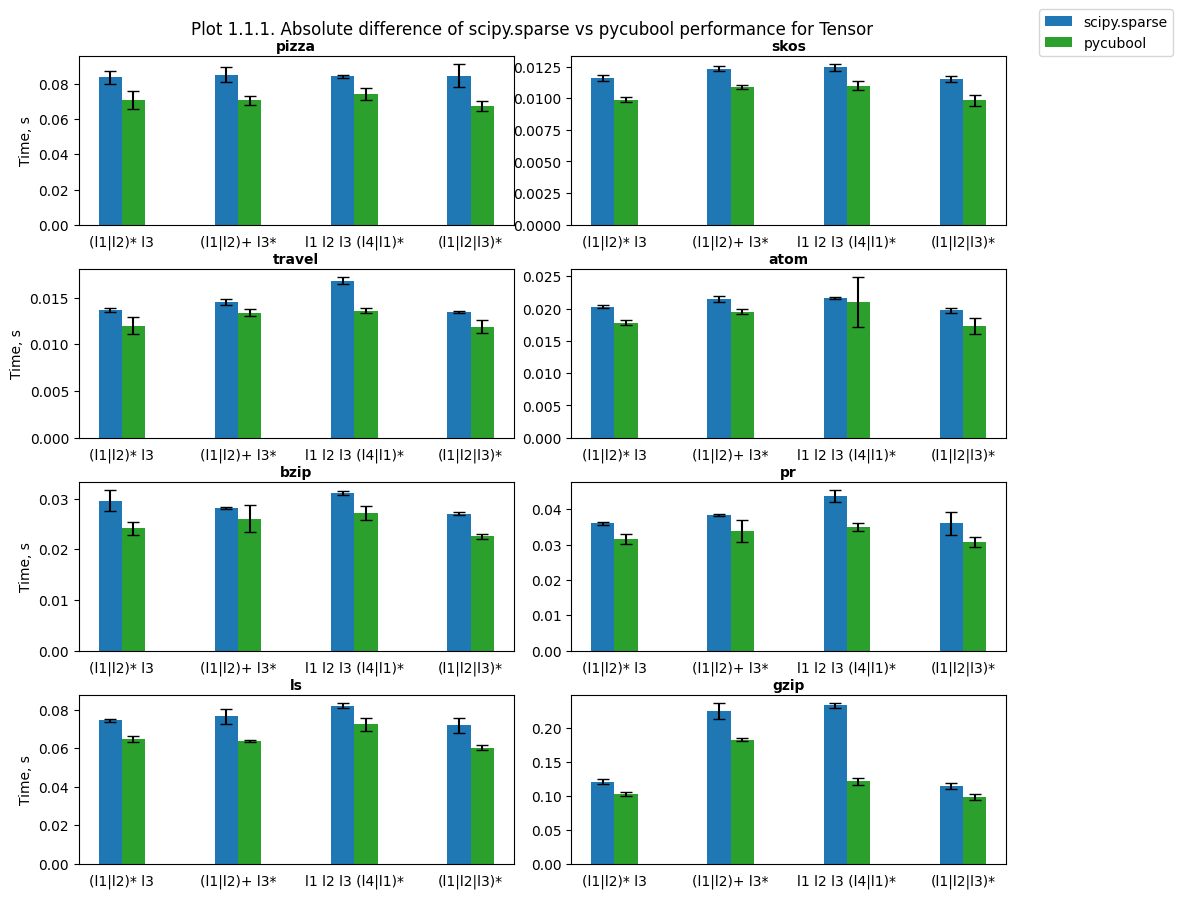

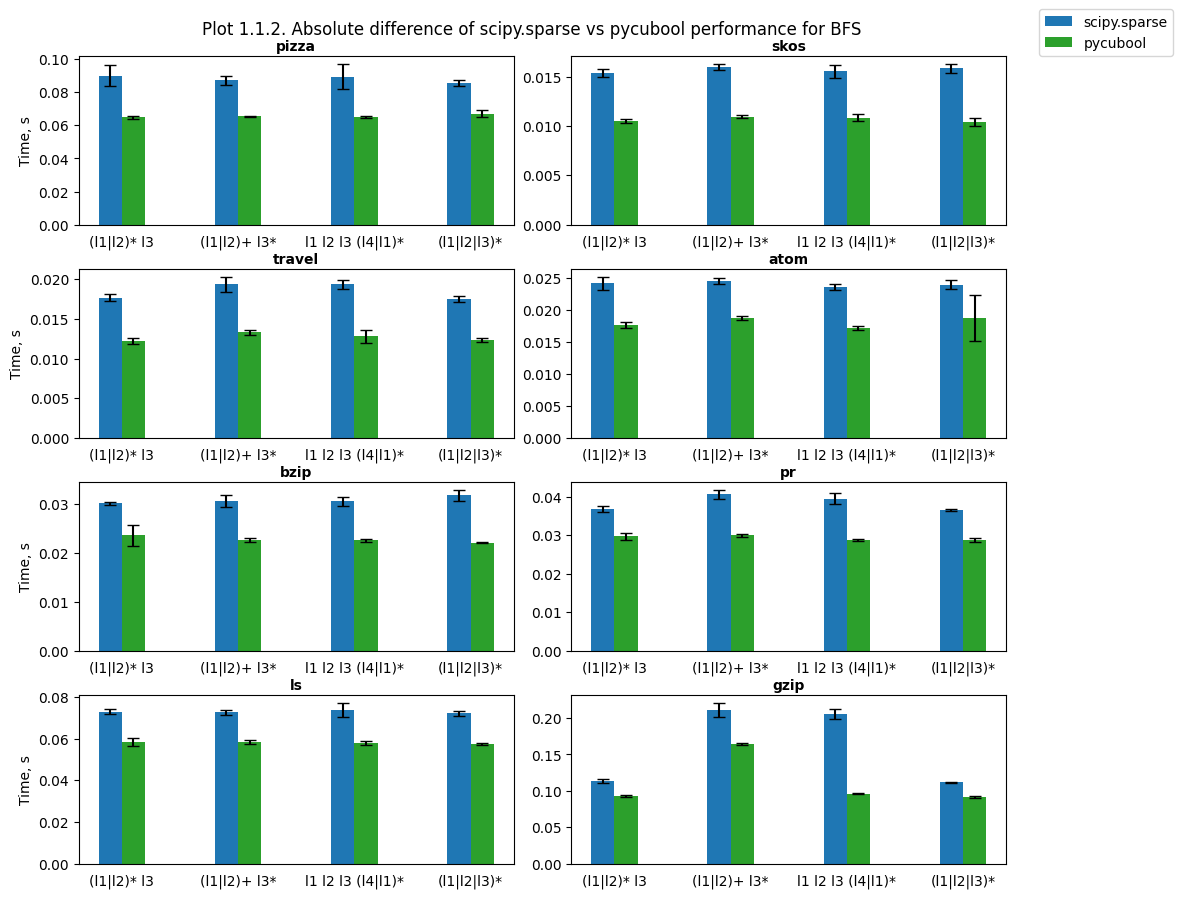

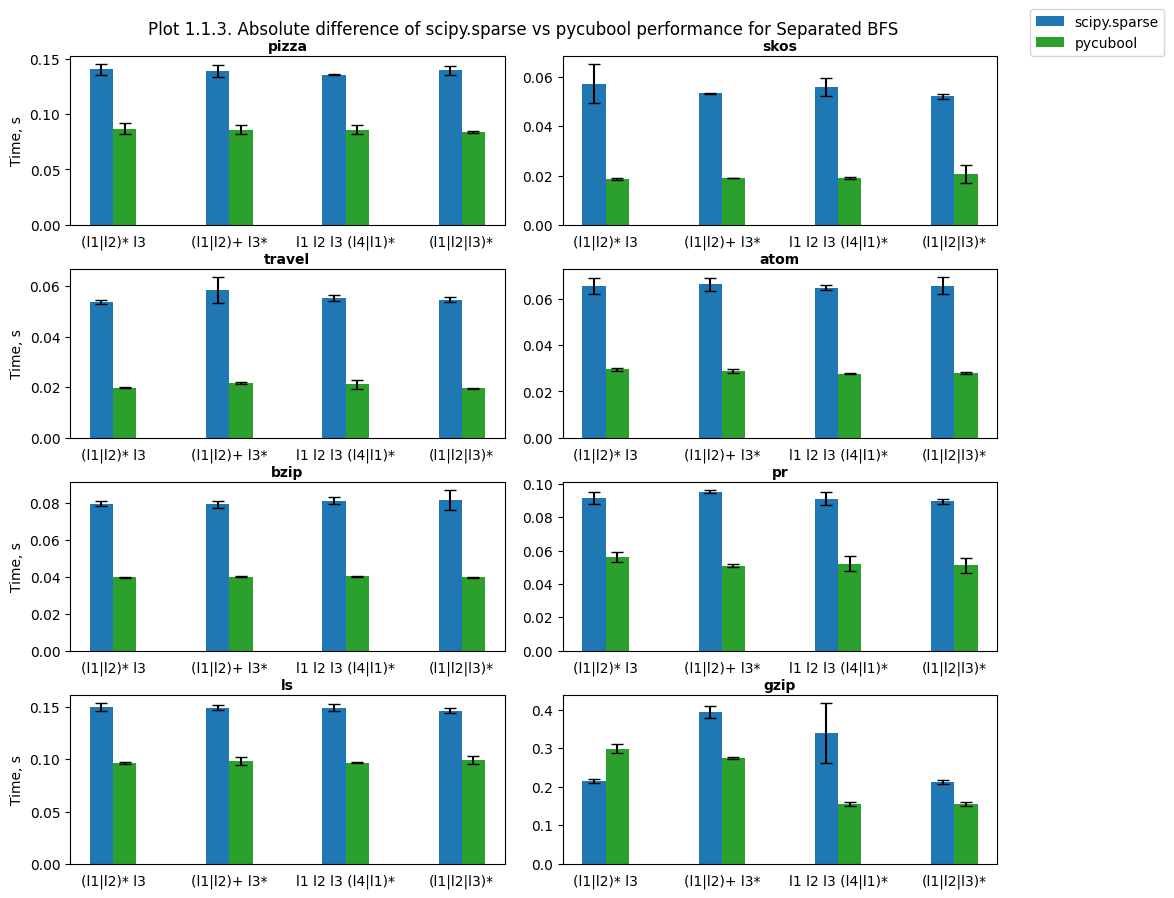

In [40]:
def batch_plots_1(res):
    fig_size = (2.5 * len(REGEXES_STR), len(GRAPHS))
    label_locations = np.arange(len(REGEXES_STR))
    bar_width = 0.2
    cap_size = 4

    for algo_i, algo_name in enumerate(ALGORITHMS):
        fig: plt.Figure
        fig, axs = plt.subplots(len(GRAPHS) // 2, 2, figsize=fig_size)

        fig.suptitle(
            f"Plot 1.1.{algo_i + 1}. Absolute difference of scipy.sparse vs pycubool performance for {algo_name}")
        fig.tight_layout()

        for g_i, ax in enumerate(axs.flat):
            graph_name = GRAPHS[g_i].name
            graph_results = res[g_i]

            ax.set_xlabel(graph_name, weight="bold")
            ax.xaxis.set_label_position("top")

            ax.set_xticks(label_locations, REGEXES_STR)
            ax.tick_params(axis='x', which='both', bottom=False)
            if not g_i % len(axs[0]):
                ax.set_ylabel("Time, s")

            scipy_means = [rs[0][algo_i][0] for rs in graph_results]
            scipy_stdevs = [rs[0][algo_i][1] for rs in graph_results]
            ax.bar(
                label_locations - bar_width / 2,
                scipy_means,
                bar_width,
                yerr=scipy_stdevs,
                color="tab:blue",
                label="scipy.sparse",
                capsize=cap_size,
            )

            pycubool_means = [rs[1][algo_i][0] for rs in graph_results]
            pycubool_stdevs = [rs[1][algo_i][1] for rs in graph_results]
            ax.bar(
                label_locations + bar_width / 2,
                pycubool_means,
                bar_width,
                yerr=pycubool_stdevs,
                color="tab:green",
                label="pycubool",
                capsize=cap_size,
            )

        handles, labels = axs[-1][-1].get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


batch_plots_1(fixed_starts_res)

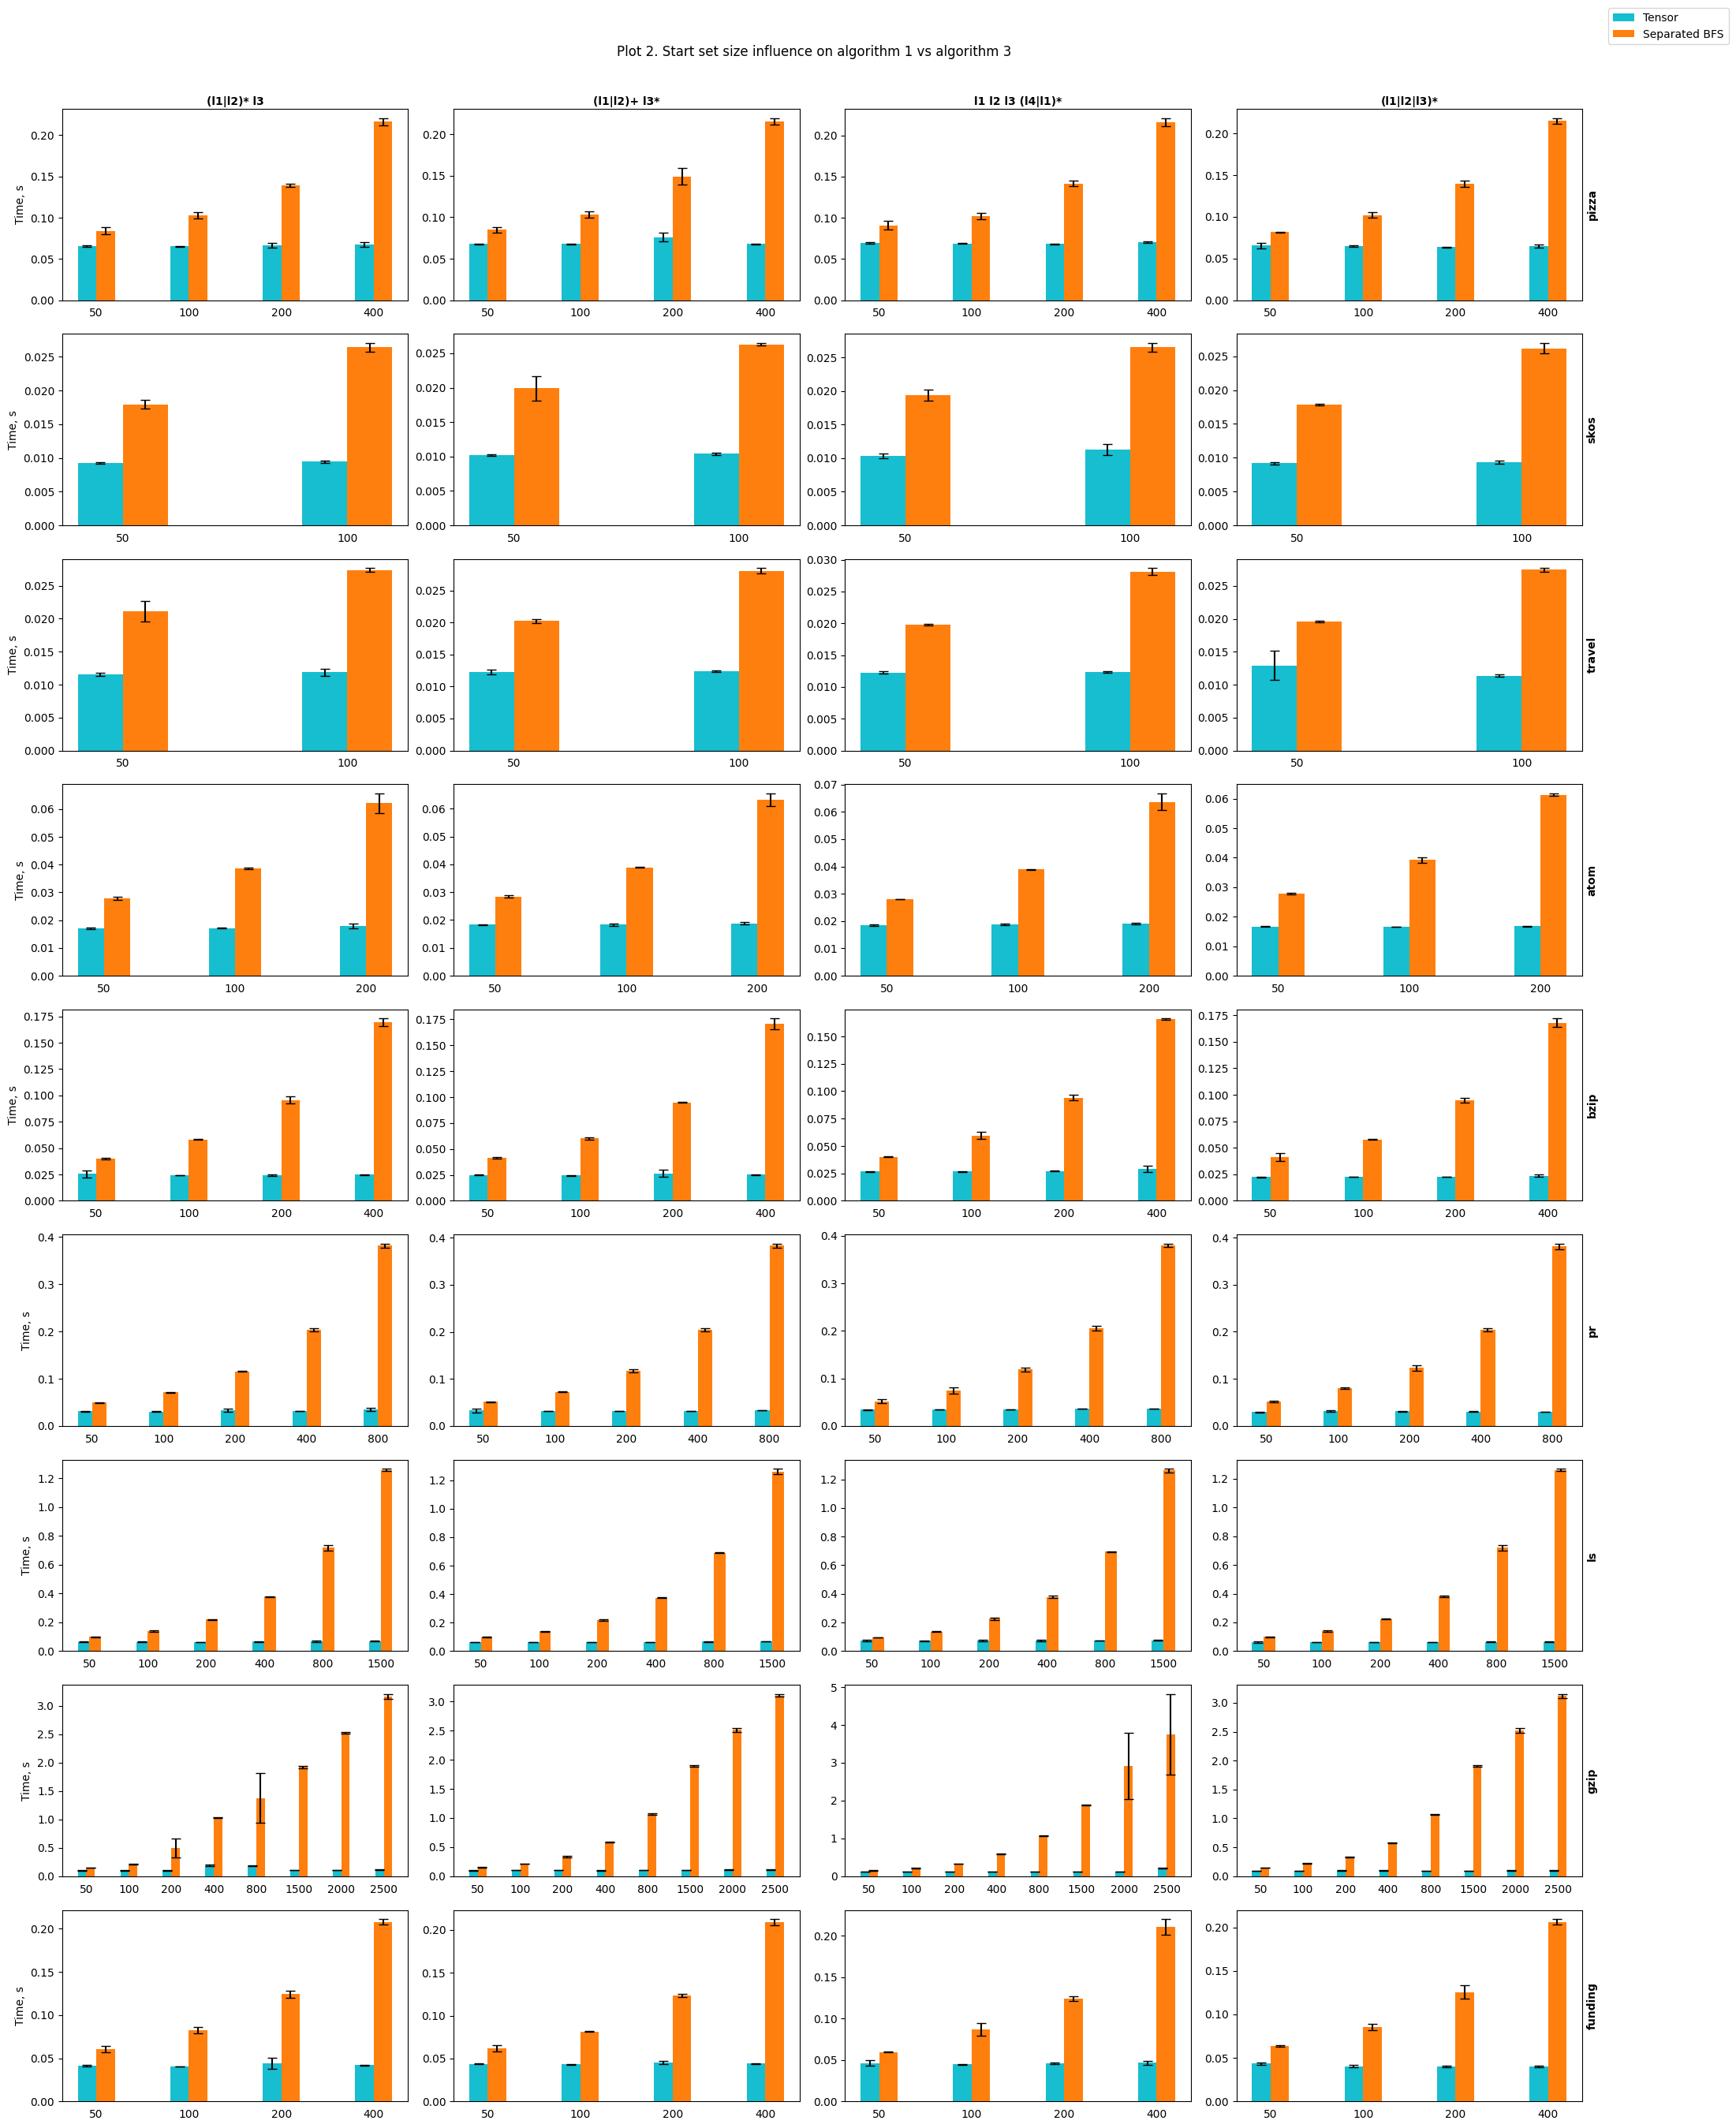

In [41]:
def batch_plots_2(res):
    fig, axs = plt.subplots(len(GRAPHS), len(REGEXES_STR), figsize=(5 * len(REGEXES_STR), 3 * len(GRAPHS)))

    fig.suptitle("Plot 2. Start set size influence on algorithm 1 vs algorithm 3")
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    bar_width = 0.2
    cap_size = 4

    for g_i, axs_row in enumerate(axs):
        graph_name = GRAPHS[g_i].name
        graph_results = res[g_i]

        for r_i, ax in enumerate(axs_row):
            regex_name = list(REGEXES_STR)[r_i]
            regex_results = graph_results[r_i]

            if not g_i:
                ax.set_xlabel(regex_name, weight="bold")
                ax.xaxis.set_label_position("top")

            if not r_i:
                ax.set_ylabel("Time, s")

            if r_i == len(REGEXES_STR) - 1:
                ax.set_ylabel(graph_name, weight="bold")
                ax.yaxis.set_label_position("right")

            label_locations = np.arange(len(regex_results))
            ax.set_xticks(label_locations, regex_results.keys())

            algo1_results = [rs[0] for rs in regex_results.values()]
            algo1_means, algo1_stdevs = zip(*algo1_results)
            ax.bar(
                label_locations - bar_width / 2,
                algo1_means,
                bar_width,
                yerr=algo1_stdevs,
                color="tab:cyan",
                label=ALGORITHMS[0],
                capsize=cap_size,
            )

            algo3_results = [rs[1] for rs in regex_results.values()]
            algo3_means, algo3_stdevs = zip(*algo3_results)
            ax.bar(
                label_locations + bar_width / 2,
                algo3_means,
                bar_width,
                yerr=algo3_stdevs,
                color="tab:orange",
                label=ALGORITHMS[2],
                capsize=cap_size,
            )

            ax.tick_params(axis='x', which='both', bottom=False)

    handles, labels = axs[-1][-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


batch_plots_2(varied_starts_res)

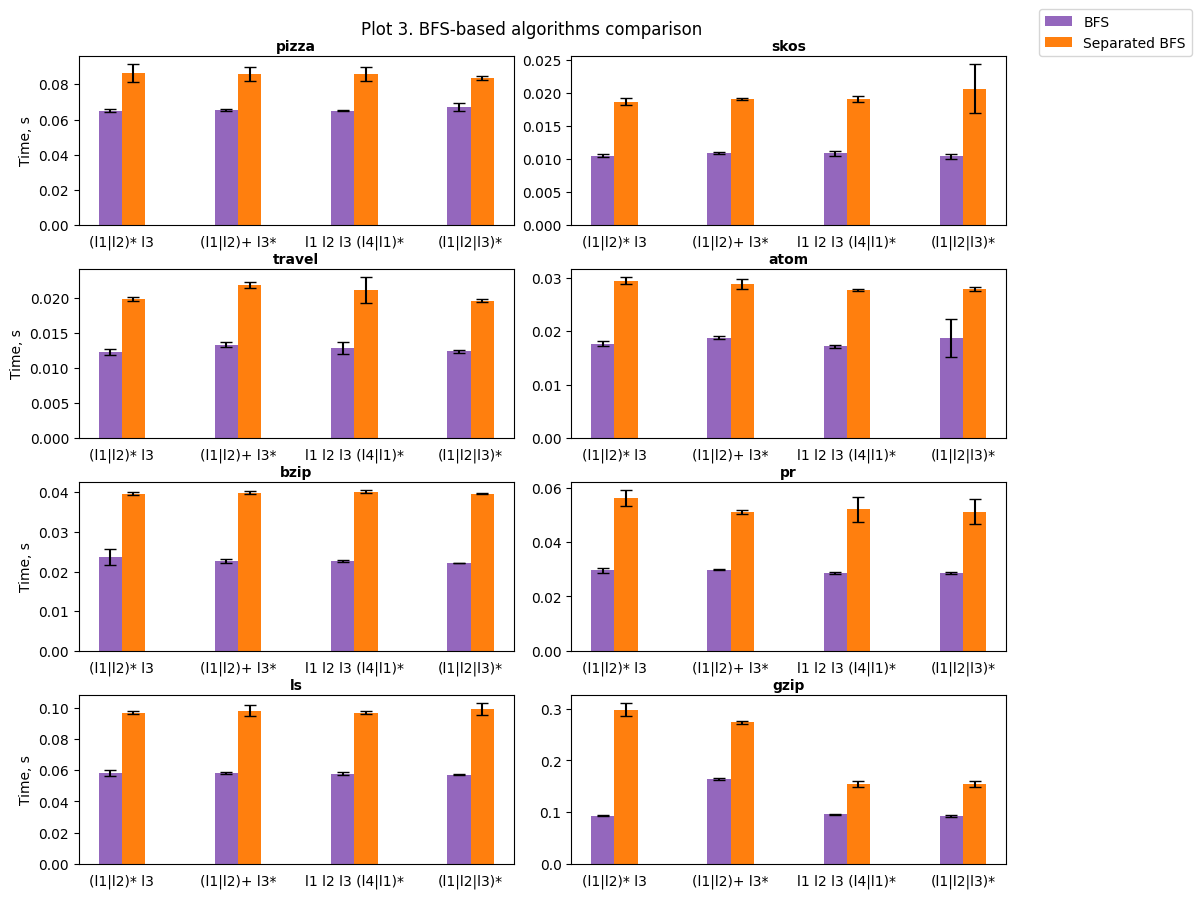

In [42]:
def batch_plots_3(res):
    fig_size = (2.5 * len(REGEXES_STR), len(GRAPHS))
    label_locations = np.arange(len(REGEXES_STR))
    bar_width = 0.2
    cap_size = 4

    fig, axs = plt.subplots(len(GRAPHS) // 2, 2, figsize=fig_size)

    fig.suptitle("Plot 3. BFS-based algorithms comparison")
    fig.tight_layout()

    for g_i, ax in enumerate(axs.flat):
        graph_name = GRAPHS[g_i].name
        graph_results = res[g_i]

        ax.set_xlabel(graph_name, weight="bold")
        ax.xaxis.set_label_position("top")

        ax.set_xticks(label_locations, REGEXES_STR)
        ax.tick_params(axis='x', which='both', bottom=False)
        if not g_i % len(axs[0]):
            ax.set_ylabel("Time, s")

        pycubool_algo2_means = [rs[1][1][0] for rs in graph_results]
        pycubool_algo2_stdevs = [rs[1][1][1] for rs in graph_results]
        ax.bar(
            label_locations - bar_width / 2,
            pycubool_algo2_means,
            bar_width,
            yerr=pycubool_algo2_stdevs,
            color="tab:purple",
            label=ALGORITHMS[1],
            capsize=cap_size,
        )

        pycubool_algo3_means = [rs[1][2][0] for rs in graph_results]
        pycubool_algo3_stdevs = [rs[1][2][1] for rs in graph_results]
        ax.bar(
            label_locations + bar_width / 2,
            pycubool_algo3_means,
            bar_width,
            yerr=pycubool_algo3_stdevs,
            color="tab:orange",
            label=ALGORITHMS[2],
            capsize=cap_size,
        )

    handles, labels = axs[-1][-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


batch_plots_3(fixed_starts_res)